# Hierarchical Kriging Demo

In [112]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../src')

from mfmodel.kriging import Kriging
from mfmodel.mfkriging import MFKriging

## 1. High and low fidelity functions

We use bifidelity analytical example from [1] to generate artificial high and low fidelity data.

[1] Meng, X., & Karniadakis, G. E. (2020). A composite neural network that learns from multi-fidelity data: Application to function approximation and inverse PDE problems. Journal of Computational Physics, 401, 109020.

(100, 1)


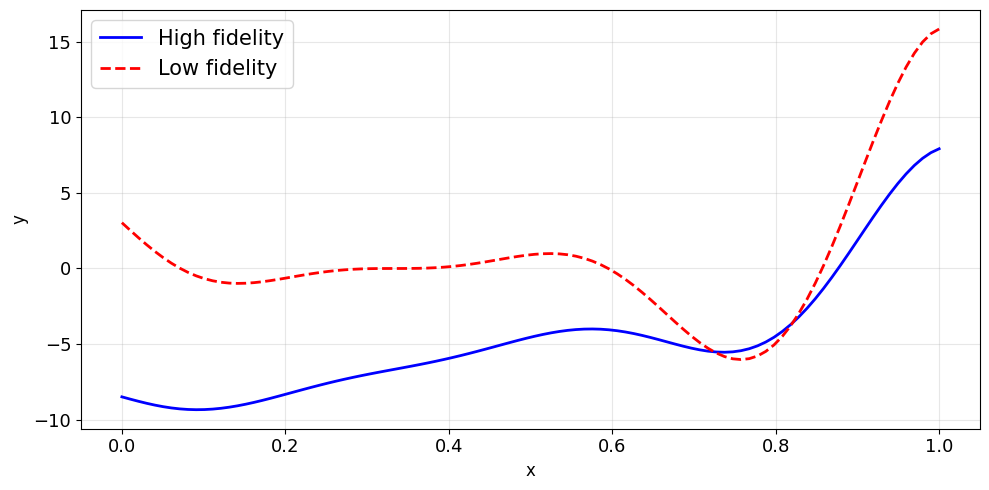

In [113]:
# function parameters
a = 0.5
b = 10
c = -5

# high fidelity function
def f_high(x):
    return a*(6*x-2)**2 * np.sin(12*x-4) + b*(x-0.5) + c

# low fidelity function
def f_low(x):
    return (6*x-2)**2 * np.sin(12*x-4)

x_plot = np.linspace(0, 1, 100).reshape(-1,1)
y_high_true = f_high(x_plot)
y_low_true = f_low(x_plot)
print(y_high_true.shape)

plt.figure(figsize=(10, 5))
plt.plot(x_plot, y_high_true, 'b-', linewidth=2, label='High fidelity')
plt.plot(x_plot, y_low_true, 'r--', linewidth=2, label='Low fidelity')
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=15)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 2. Single fidelity Kriging

In [114]:
# generate training samples for single fidelity Kriging

np.random.seed(101)
n_sf = 8  # budget
x_train_sf = np.random.uniform(0, 1, n_sf).reshape(-1, 1)
y_train_sf = f_high(x_train_sf.ravel()).reshape(-1, 1)

print(f"Number of single fidelity training samples: {n_sf}")

# train single fidelity kriging model
sf_model = Kriging(kernel='ardmatern32', regularize=True, normalize=True, n_restart=5)
sf_model.train(x_train_sf, y_train_sf)
print("Single fidelity model trained.")

# predict on test points
x_test = x_plot.reshape(-1, 1)
y_pred_sf, var_pred_sf = sf_model.predict(x_test, return_var=True)
std_pred_sf = np.sqrt(np.abs(var_pred_sf)).ravel()

Number of single fidelity training samples: 8
Single fidelity model trained.


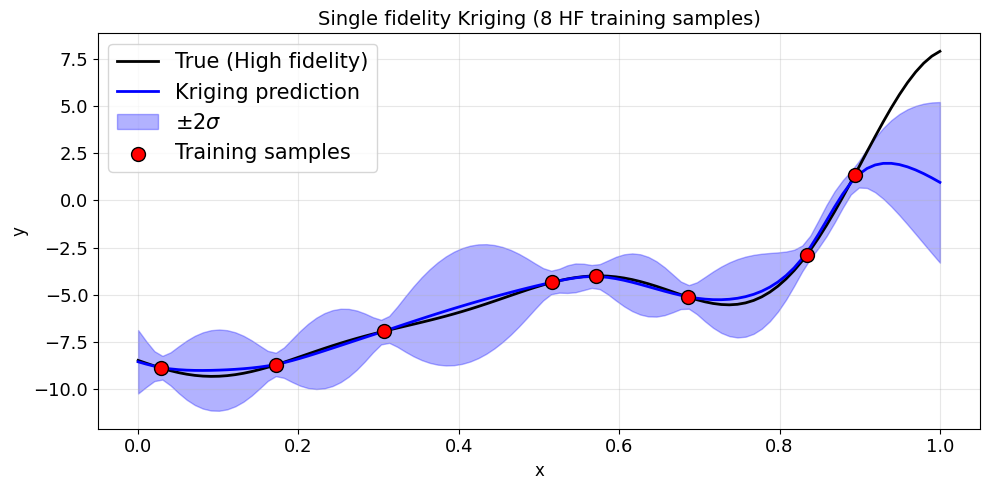

In [115]:
# plot single fidelity Kriging prediction
plt.figure(figsize=(10, 5))
plt.plot(x_plot, y_high_true, 'k-', linewidth=2, label='True (High fidelity)')
plt.plot(x_plot, y_pred_sf.ravel(), 'b-', linewidth=2, label='Kriging prediction')
plt.fill_between(x_plot.ravel(), 
                 y_pred_sf.ravel() - 2*std_pred_sf, 
                 y_pred_sf.ravel() + 2*std_pred_sf, 
                 alpha=0.3, color='blue', label=r'$\pm 2\sigma$')
plt.scatter(x_train_sf.ravel(), y_train_sf.ravel(), 
            c='red', s=100, zorder=5, edgecolors='black', label='Training samples')
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title(f'Single fidelity Kriging ({n_sf} HF training samples)', fontsize=14)
plt.legend(fontsize=15)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('demo_prediction_sf.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Hierarchical Kriging with MFMC Allocation

### Setup

In [116]:
import h5py
import os
from mfmc import MFMC

# set up
budget = n_sf # total budget
w1 = 1.0      # high fidelity cost
w2 = 0.1      # low fidelity cost
w = np.array([w1, w2])
cost = np.array([w1, w2])

### Step 1: compute second-order statistics

In [117]:
n_samples_stat = 1000
x_stat = np.random.uniform(0, 1, n_samples_stat)
y_h_stat = f_high(x_stat).reshape(-1, 1)
y_l_stat = f_low(x_stat).reshape(-1, 1)
os.makedirs('../../data/demo', exist_ok=True)
with h5py.File('../../data/demo/highfi.h5', 'w') as f:
    f.create_dataset('output', data=y_h_stat)
with h5py.File('../../data/demo/lowfi.h5', 'w') as f:
    f.create_dataset('output', data=y_l_stat)
mfmc = MFMC('../../data/demo/highfi.h5', '../../data/demo/lowfi.h5', cost)
sigma, rho = mfmc.stats()

### Step 2: allocate samples using MFMC

Define $\tau=\dfrac{\text{number of low fidelity samples}}{\text{number of high fidelity samples}}$.

In [118]:
m, const = mfmc.alloc(sigma, rho, budget)
n_high = int(m[0])
n_low = int(m[1])
print(f"MFMC Statistics:")
print(f"standard deviation = {sigma}")
print(f"correlation coefficient = {rho[:-1]}")
print(rf"MFMC allocation \tau = {const[1]:.2f}")
print(f"n (HF samples) = {n_high}")
print(f"m (LF samples) = {n_low}")
print(f"Actual budget used: {n_high*w1 + n_low*w2:.2f}")

# generate nested samples: HF is a subset of LF
np.random.seed(101)
# generate LF samples
x_train_low = np.random.uniform(0, 1, n_low).reshape(-1, 1)
y_train_low = f_low(x_train_low.ravel()).reshape(-1, 1)

# generate HF samples (set first n_high points from LF as training data)
x_train_high = x_train_low[:n_high]
y_train_high = f_high(x_train_high.ravel()).reshape(-1, 1)

MFMC Statistics:
standard deviation = [4.04513488 4.34413211]
correlation coefficient = [1.         0.73324731]
MFMC allocation \tau = 3.41
n (HF samples) = 5
m (LF samples) = 20
Actual budget used: 7.00


### Step 3: train hierarchical Kriging model

In [119]:
mf_model = MFKriging(kernel='ardmatern32', regularize=True, normalize=True, n_restart=5)
mf_model.train(x_train_low, y_train_low, x_train_high, y_train_high)
print("Hierarchical Kriging model (with MFMC allocation) trained.")

# predict on test points
y_pred_mf, var_pred_mf = mf_model.predict(x_test, return_var=True)
std_pred_mf = np.sqrt(np.abs(var_pred_mf)).ravel()

Hierarchical Kriging model (with MFMC allocation) trained.


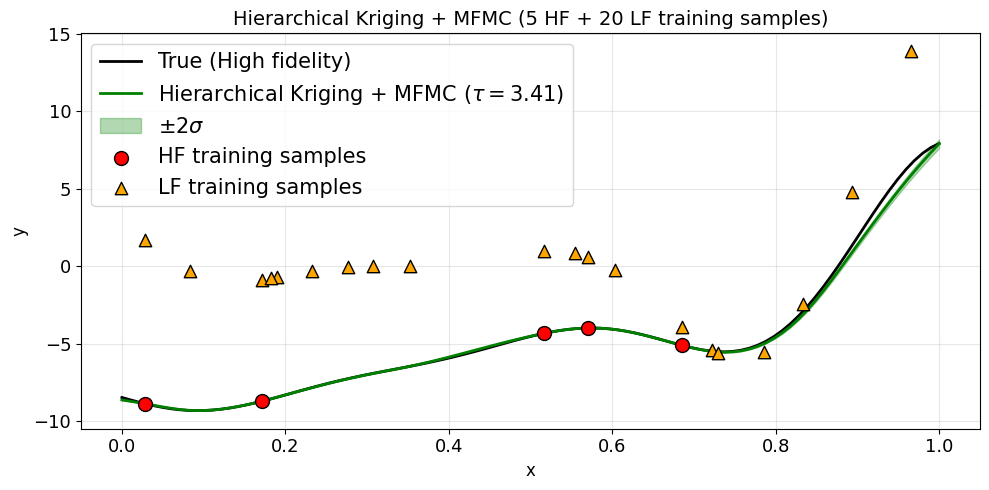

In [120]:
# plot hierarchical Kriging prediction
plt.figure(figsize=(10, 5))
plt.plot(x_plot, y_high_true, 'k-', linewidth=2, label='True (High fidelity)')
plt.plot(x_plot, y_pred_mf.ravel(), 'g-', linewidth=2, label=rf'Hierarchical Kriging + MFMC ($\tau={const[1]:.2f}$)')
plt.fill_between(x_plot.ravel(), 
                 y_pred_mf.ravel() - 2*std_pred_mf, 
                 y_pred_mf.ravel() + 2*std_pred_mf, 
                 alpha=0.3, color='green', label=r'$\pm 2\sigma$')
plt.scatter(x_train_high.ravel(), y_train_high.ravel(), 
            c='red', s=100, zorder=5, edgecolors='black', label='HF training samples')
plt.scatter(x_train_low.ravel(), y_train_low.ravel(), 
            c='orange', s=80, zorder=4, edgecolors='black', marker='^', label='LF training samples')
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title(rf'Hierarchical Kriging + MFMC ({n_high} HF + {n_low} LF training samples)', fontsize=14)
plt.legend(fontsize=15)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('demo_prediction_mf.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Hierarchical Kriging with naive allocation
Naive allocation allocates samples as
- n = p / (w1 + w2 * $\tau$)  (number of HF samples)
- m = $\tau$ * n              (number of LF samples),

where
* p: computational budget
* w1: high fidelity model evaluation cost
* w2: low fidelity model evaluation cost

We compare MFMC allocation with $\tau$ = 2, 4, 8.

In [121]:
# naive allocation for tau = 2, 4, 8
p = budget
tau_values = [2, 4, 8]

# compute naive allocations
n_naive = np.zeros(len(tau_values), dtype=int)
m_naive = np.zeros(len(tau_values), dtype=int)

for j, tau in enumerate(tau_values):
    n_naive[j] = int(np.floor(p / (w[0] + w[1] * tau)))
    m_naive[j] = int(np.floor(tau * n_naive[j]))

print("Naive allocation:")
for j, tau in enumerate(tau_values):
    actual_budget = n_naive[j] * w[0] + m_naive[j] * w[1]
    print(f"  tau={tau}: n={n_naive[j]}, m={m_naive[j]}, Actual budget used={actual_budget:.2f}")

Naive allocation:
  tau=2: n=6, m=12, Actual budget used=7.20
  tau=4: n=5, m=20, Actual budget used=7.00
  tau=8: n=4, m=32, Actual budget used=7.20


In [122]:
# train models for each naive allocation
naive_predictions = []
for j, tau in enumerate(tau_values):
    
    # generate nested samples
    np.random.seed(101)  # use same seed with MFMC allocation
    x_low_naive = np.random.uniform(0, 1, m_naive[j]).reshape(-1, 1)
    y_low_naive = f_low(x_low_naive.ravel()).reshape(-1, 1)
    
    x_high_naive = x_low_naive[:n_naive[j]]
    y_high_naive = f_high(x_high_naive.ravel()).reshape(-1, 1)
    
    # train hierarchical Kriging model
    model_naive = MFKriging(kernel='ardmatern32', regularize=True, normalize=True, n_restart=5)
    model_naive.train(x_low_naive, y_low_naive, x_high_naive, y_high_naive)
    print(f"Hierarchical Kriging model (with tau={tau}) trained.")

    # predict
    y_pred_naive, var_pred_naive = model_naive.predict(x_test, return_var=True)
    naive_predictions.append(y_pred_naive)


Hierarchical Kriging model (with tau=2) trained.
Hierarchical Kriging model (with tau=4) trained.
Hierarchical Kriging model (with tau=8) trained.


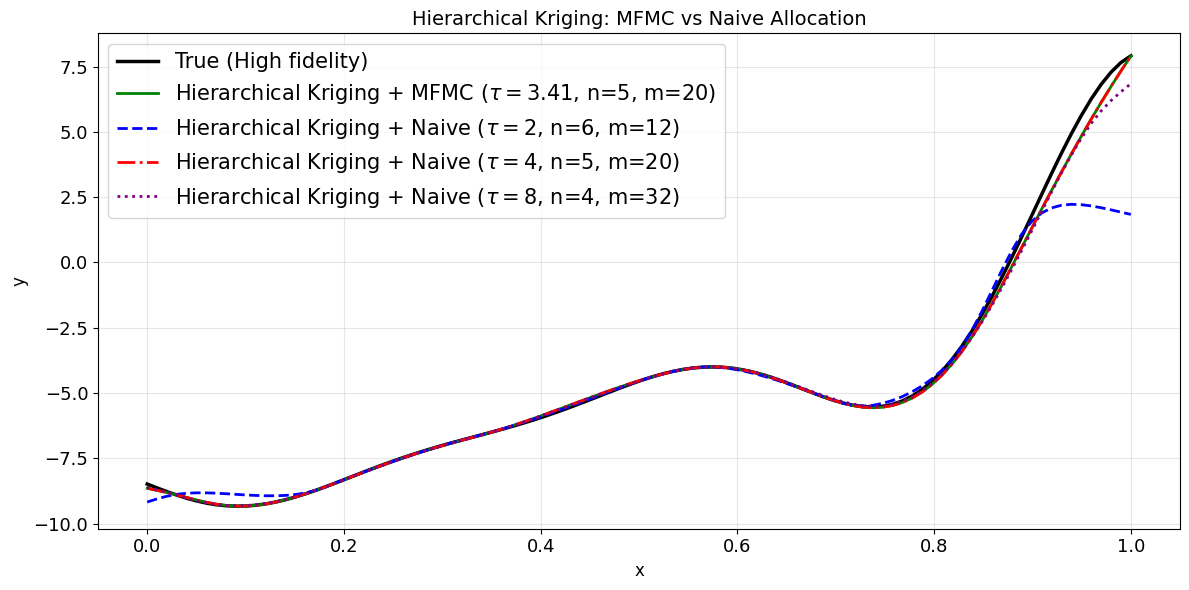

In [123]:
# plot comparison: MFMC + 3 naive allocations
plt.figure(figsize=(12, 6))
plt.plot(x_plot, y_high_true, 'k-', linewidth=2.5, label='True (High fidelity)')
plt.plot(x_plot, y_pred_mf.ravel(), 'g-', linewidth=2, label=rf'Hierarchical Kriging + MFMC ($\tau={const[1]:.2f}$, n={n_high}, m={n_low})')
colors = ['blue', 'red', 'purple']
linestyles = ['--', '-.', ':']
for j, tau in enumerate(tau_values):
    plt.plot(x_plot, naive_predictions[j].ravel(), 
             color=colors[j], linestyle=linestyles[j], linewidth=2,
             label=rf'Hierarchical Kriging + Naive ($\tau={tau}$, n={n_naive[j]}, m={m_naive[j]})')
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('Hierarchical Kriging: MFMC vs Naive Allocation', fontsize=14)
plt.legend(fontsize=15, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Relative errors of differernt allocations

Run hierarchical Kriging with MFMC and naive allocations ($\tau$=2,4,8) for 300 sample replicates and compute mean squared error across replicates.

In [124]:
n_replicates = 300

# initialize MSE
mse_mfmc = np.zeros(n_replicates)
mse_naive = {tau: np.zeros(n_replicates) for tau in tau_values}

for rep in range(n_replicates):
    if (rep + 1) % 20 == 0:
        print(f"  Replicate {rep + 1}/{n_replicates}")
    
    seed = rep + 1000  # different seed for each replicate
    
    # --- MFMC allocation ---
    np.random.seed(seed)
    x_low = np.random.uniform(0, 1, n_low).reshape(-1, 1)
    y_low = f_low(x_low.ravel()).reshape(-1, 1)
    x_high = x_low[:n_high]
    y_high = f_high(x_high.ravel()).reshape(-1, 1)
    
    model_mfmc = MFKriging(kernel='ardmatern32', regularize=True, normalize=True, n_restart=5)
    model_mfmc.train(x_low, y_low, x_high, y_high)
    y_pred, _ = model_mfmc.predict(x_test, return_var=True)
    mse_mfmc[rep] = np.mean((y_high_true.ravel() - y_pred.ravel())**2)
    
    # --- naive allocation ---
    for j, tau in enumerate(tau_values):
        n_n = n_naive[j]
        m_n = m_naive[j]
        
        np.random.seed(seed)
        x_low_n = np.random.uniform(0, 1, m_n).reshape(-1, 1)
        y_low_n = f_low(x_low_n.ravel()).reshape(-1, 1)
        x_high_n = x_low_n[:n_n]
        y_high_n = f_high(x_high_n.ravel()).reshape(-1, 1)
        
        model_naive = MFKriging(kernel='ardmatern32', regularize=True, normalize=True, n_restart=5)
        model_naive.train(x_low_n, y_low_n, x_high_n, y_high_n)
        y_pred_n, _ = model_naive.predict(x_test, return_var=True)
        mse_naive[tau][rep] = np.mean((y_high_true.ravel() - y_pred_n.ravel())**2)


  Replicate 20/300
  Replicate 40/300
  Replicate 60/300
  Replicate 80/300
  Replicate 100/300
  Replicate 120/300
  Replicate 140/300
  Replicate 160/300
  Replicate 180/300
  Replicate 200/300
  Replicate 220/300
  Replicate 240/300
  Replicate 260/300
  Replicate 280/300
  Replicate 300/300


In [125]:
# print mean MSE results
print("="*70)
print(f"Mean MSE using {n_replicates} replicates")
print("="*70)

print(f"\n{'Method':<35} {'Mean MSE':<15}")
print("-"*70)

# MFMC results
mean_mse_mfmc = np.mean(mse_mfmc)
std_mse_mfmc = np.std(mse_mfmc)
print(f"{'MFMC':<35} {mean_mse_mfmc:<15.6f}")

# Naive results
for tau in tau_values:
    mean_mse = np.mean(mse_naive[tau])
    std_mse = np.std(mse_naive[tau])
    method_name = f"Naive (tau={tau})"
    print(f"{method_name:<35} {mean_mse:<15.6f}")

print("="*70)

Mean MSE using 300 replicates

Method                              Mean MSE       
----------------------------------------------------------------------
MFMC                                0.696258       
Naive (tau=2)                       1.842972       
Naive (tau=4)                       0.696258       
Naive (tau=8)                       5.991896       
